In [1]:
import pandas as pd
import os

In [2]:
file_paths = {
    "VDJdb_beta": vdjdb_beta_read_path,
    "McPAS_beta": mcpastcr_beta_read_path,
    "IEDB_beta": iedb_beta_read_path,
    "pMTnet_beta": pmtnet_beta_read_path,
    "VDJdb_paired": vdjdb_paired_read_path,
    "McPAS_paired": mcpastcr_paired_read_path,
    "IEDB_paired": iedb_paired_read_path
}

NameError: name 'vdjdb_beta_read_path' is not defined

In [ ]:
import pandas as pd
import os

# Function to classify tasks based on TCR and epitope presence
def calculate_task(row, known_epitopes, known_tcr, paired=False):
    if paired:
        tra_cdr3 = str(row['TRA_CDR3']) if pd.notna(row['TRA_CDR3']) else ''
        trb_cdr3 = str(row['TRB_CDR3']) if pd.notna(row['TRB_CDR3']) else ''
        tcr = tra_cdr3 + '_' + trb_cdr3
    else:
        tcr = row['TRB_CDR3']
    
    epitope_exists = row['Epitope'] in known_epitopes
    cdr3_exists = tcr in known_tcr
    
    if epitope_exists and cdr3_exists:
        return 'TPP1'
    elif epitope_exists and not cdr3_exists:
        return 'TPP2'
    elif not epitope_exists and not cdr3_exists:
        return 'TPP3'
    elif not epitope_exists and cdr3_exists:
        return 'TPP4'
    raise Exception("Something seems wrong")

# Placeholder for the data
all_data = {}

# Load and prepare data
for file_name, path in file_paths.items():
    if os.path.exists(path):
        try:
            df = pd.read_csv(path, sep=None, engine="python")

            # Create tcr_key
            if "TRA_CDR3" in df.columns:
                paired = True
                df["tcr_key"] = df["TRA_CDR3"].astype(str) + '_' + df["TRB_CDR3"]
            else:
                paired = False
                df["tcr_key"] = df["TRB_CDR3"]

            all_data[file_name] = df
            print(f"{file_name} geladen mit {len(df)} Einträgen.")

        except Exception as e:
            print(f"Fehler beim Verarbeiten der Datei {file_name}: {e}")
    else:
        print(f"Datei nicht gefunden: {file_name}")

# Analyse: Classify TPP tasks
for test_file_name, test_df in all_data.items():
    # Define training data (excluding the current test set)
    train_df = pd.concat([data for name, data in all_data.items() if name != test_file_name]).drop_duplicates()

    seen_tcrs = set(train_df["tcr_key"])
    seen_epitopes = set(train_df["Epitope"])

    # Determine if it's a paired dataset
    paired = "TRA_CDR3" in test_df.columns

    # Apply classification
    test_df['task'] = test_df.apply(lambda row: calculate_task(row, seen_epitopes, seen_tcrs, paired=paired), axis=1)

    # Count TPP3 pairs
    tpp3_pairs = (test_df['task'] == 'TPP3').sum()

    # Print the results
    print(f"\n**Wenn {test_file_name} als Testset verwendet wird:**")
    print(f"  - TPP3-Paare im Testset: {tpp3_pairs}")
    print(f"  - Gesamt Test-Paare: {len(test_df)}")


In [ ]:
import pandas as pd
import os

# Function to classify TPP tasks based on TCR and epitope presence
def calculate_task(row, known_epitopes, known_tcr, paired=False):
    if paired:
        tra_cdr3 = str(row['TRA_CDR3']) if pd.notna(row['TRA_CDR3']) else ''
        trb_cdr3 = str(row['TRB_CDR3']) if pd.notna(row['TRB_CDR3']) else ''
        tcr = tra_cdr3 + '_' + trb_cdr3
    else:
        tcr = row['TRB_CDR3']
    
    epitope_exists = row['Epitope'] in known_epitopes
    cdr3_exists = tcr in known_tcr
    
    if epitope_exists and cdr3_exists:
        return 'TPP1'
    elif epitope_exists and not cdr3_exists:
        return 'TPP2'
    elif not epitope_exists and not cdr3_exists:
        return 'TPP3'
    elif not epitope_exists and cdr3_exists:
        return 'TPP4'
    raise Exception("Something seems wrong")


# Load train and validation data
train_file = f'{pipeline_data_splitted}/{precision}/beta/train.tsv'
validation_file = f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
test_file = f'{pipeline_data_splitted}/{precision}/beta/test.tsv'
vdjdb_test_file = vdjdb_beta_read_path  # Path to the VDJdb test dataset

df_train = pd.read_csv(train_file, sep='\t')
df_validation = pd.read_csv(validation_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')

# Combine train and validation datasets
trainval_df = pd.concat([df_train, df_validation], ignore_index=True)

# Load VDJdb test data
vdjdb_df = pd.read_csv(vdjdb_test_file, sep='\t') #f'{pipeline_data_cleaned}/VDJdb/VDJdb_cleaned_data_beta.tsv'

# Create tcr_key and clean data
trainval_df["tcr_key"] = trainval_df["TRB_CDR3"].astype(str).str.strip()
trainval_df["Epitope"] = trainval_df["Epitope"].astype(str).str.strip()

vdjdb_df["tcr_key"] = vdjdb_df["TRB_CDR3"].astype(str).str.strip()
vdjdb_df["Epitope"] = vdjdb_df["Epitope"].astype(str).str.strip()

df_test["tcr_key"] = df_test["TRB_CDR3"].astype(str).str.strip()
df_test["Epitope"] = df_test["Epitope"].astype(str).str.strip()

# Generate lookup sets for fast comparison
seen_tcrs = set(trainval_df["tcr_key"])
seen_epitopes = set(trainval_df["Epitope"])

# Apply classification to the VDJdb dataset
vdjdb_df['task'] = vdjdb_df.apply(lambda row: calculate_task(row, seen_epitopes, seen_tcrs, paired=False), axis=1)

# Count TPP3 pairs
tpp3_pairs = (vdjdb_df['task'] == 'TPP3').sum()

# Print the results
print(f"\n**TPP Analysis for VDJdb with Train + Validation**")
print(f"  - TPP3-Paare im Testset: {tpp3_pairs}")
print(f"  - Gesamt Test-Paare: {len(vdjdb_df)}")


In [ ]:
# Original TPP3 Paare vor dem Hinzufügen negativer Daten
original_tpp3 = vdjdb_df[(vdjdb_df['task'] == 'TPP3')][["tcr_key", "Epitope"]]

# Prüfen, ob diese TPP3-Paare in den negativen Daten des Train/Validation-Sets auftauchen
negative_in_trainval = trainval_df[trainval_df['Binding'] == 0][["tcr_key", "Epitope"]]

# Vergleichen
tpp3_now_seen = original_tpp3.merge(negative_in_trainval, on=["tcr_key", "Epitope"], how="inner")

print(f"Anzahl der ursprünglichen TPP3-Paare, die jetzt in negativen Daten des Train/Validation-Sets vorkommen: {len(tpp3_now_seen)}")

# Zeige einige Beispiele
if not tpp3_now_seen.empty:
    print(tpp3_now_seen.head(10))
else:
    print("Keine der ursprünglichen TPP3-Paare wurden in den negativen Daten gefunden.")

# Prüfen, ob die ursprünglichen TPP3-Paare in den positiven Daten des Train/Validation-Sets enthalten sind
positive_in_trainval = trainval_df[trainval_df['Binding'] == 1][["tcr_key", "Epitope"]]

# Vergleich durchführen
tpp3_in_pos_trainval = original_tpp3.merge(positive_in_trainval, on=["tcr_key", "Epitope"], how="inner")

print(f"Anzahl der ursprünglichen TPP3-Paare, die jetzt in den positiven Train/Validation-Daten vorkommen: {len(tpp3_in_pos_trainval)}")

In [ ]:
# Paths to the concatenated files
concatenated_beta_file = f'{pipeline_data_concatenated}/{precision}/beta_concatenated.tsv'
vdjdb_test_file = vdjdb_beta_read_path  # Path to the original VDJdb data

# Load concatenated beta data
concatenated_beta_df = pd.read_csv(concatenated_beta_file, sep='\t')

# Load original VDJdb dataset
vdjdb_df = pd.read_csv(vdjdb_test_file, sep='\t')

# Create tcr_key and clean data
concatenated_beta_df["tcr_key"] = concatenated_beta_df["TRB_CDR3"].astype(str).str.strip()
concatenated_beta_df["Epitope"] = concatenated_beta_df["Epitope"].astype(str).str.strip()

vdjdb_df["tcr_key"] = vdjdb_df["TRB_CDR3"].astype(str).str.strip()
vdjdb_df["Epitope"] = vdjdb_df["Epitope"].astype(str).str.strip()

# Generate lookup sets from concatenated data
seen_tcrs = set(concatenated_beta_df["tcr_key"])
seen_epitopes = set(concatenated_beta_df["Epitope"])

# Apply classification to the VDJdb dataset
vdjdb_df['task'] = vdjdb_df.apply(lambda row: calculate_task(row, seen_epitopes, seen_tcrs, paired=False), axis=1)

# Count TPP3 pairs
tpp3_pairs = (vdjdb_df['task'] == 'TPP3').sum()

# Print the results
print(f"\n**TPP Analysis for VDJdb with Concatenated Beta Data**")
print(f"  - TPP3-Paare im Testset: {tpp3_pairs}")
print(f"  - Gesamt Test-Paare: {len(vdjdb_df)}")

In [ ]:
# Negative Daten aus Train/Validation
negative_in_trainval = trainval_df[trainval_df['Binding'] == 0][["tcr_key", "Epitope"]]
negative_in_test = df_test[df_test['Binding'] == 0][["tcr_key", "Epitope"]]

# Prüfen, ob VDJdb-TCRs in den negativen Daten vorkommen
tpp3_tcr_overlap = vdjdb_df[~vdjdb_df['tcr_key'].isin(seen_tcrs) & vdjdb_df['tcr_key'].isin(set(negative_in_trainval['tcr_key']))]
tpp3_tcr_overlap_test = vdjdb_df[~vdjdb_df['tcr_key'].isin(seen_tcrs) & vdjdb_df['tcr_key'].isin(set(negative_in_test['tcr_key']))]

# Prüfen, ob VDJdb-Epitope in den negativen Daten vorkommen
tpp3_epitope_overlap = vdjdb_df[~vdjdb_df['Epitope'].isin(seen_epitopes) & vdjdb_df['Epitope'].isin(set(negative_in_trainval['Epitope']))]
tpp3_epitope_overlap_test = vdjdb_df[~vdjdb_df['Epitope'].isin(seen_epitopes) & vdjdb_df['Epitope'].isin(set(negative_in_trainval['Epitope']))]

print(f"VDJdb TPP3-Paare, deren TCR jetzt in negativen Daten aus Train/Validation vorkommt: {len(tpp3_tcr_overlap)}")
print(f"VDJdb TPP3-Paare, deren Epitope jetzt in negativen Daten aus Train/Validation vorkommt: {len(tpp3_epitope_overlap)}")

In [ ]:
# Load VDJdb test data
vdjdb_df = pd.read_csv(vdjdb_test_file, sep='\t') #f'{pipeline_data_cleaned}/VDJdb/VDJdb_cleaned_data_beta.tsv'
vdjdb_df["tcr_key"] = vdjdb_df["TRB_CDR3"].astype(str).str.strip()
vdjdb_df["Epitope"] = vdjdb_df["Epitope"].astype(str).str.strip()
vdjdb_df['task'] = vdjdb_df.apply(lambda row: calculate_task(row, seen_epitopes, seen_tcrs, paired=False), axis=1)
# TPP3-Paare aus dem vdjdb File
original_tpp3 = vdjdb_df[vdjdb_df['task'] == 'TPP3'][["tcr_key", "Epitope"]]
# Prüfen, ob diese TPP3-Paare im finalen Testset noch vorhanden sind
tpp3_in_test = original_tpp3.merge(df_test, on=["tcr_key", "Epitope"], how="inner")
print(f"TPP3-Paare von cleaned data, die noch im finalen Testset vorhanden sind: {len(tpp3_in_test)}")

# Prüfen, welche TPP-Klasse die TPP3-Paare jetzt im finalen Testset haben
tpp3_in_test_with_task = original_tpp3.merge(df_test, on=["tcr_key", "Epitope"], how="inner")

# Zählen, wie viele der ursprünglichen TPP3-Paare jetzt welcher TPP-Klasse zugeordnet wurden
task_distribution = tpp3_in_test_with_task['task'].value_counts()

print(f"\n✅ TPP3-Paare von cleaned data, die noch im finalen Testset vorhanden sind: {len(tpp3_in_test_with_task)}")
print(f"🔄 Aktuelle TPP-Klassen dieser Paare im finalen Testset:")
print(task_distribution)

In [ ]:
# Prüfen, ob TCRs in negativen Daten des Train/Validation-Sets vorkommen
tcrs_in_negative_trainval = original_tpp3[original_tpp3['tcr_key'].isin(trainval_df[trainval_df['Binding'] == 0]['tcr_key'])]

# Prüfen, ob Epitope in negativen Daten des Train/Validation-Sets vorkommen
epitopes_in_negative_trainval = original_tpp3[original_tpp3['Epitope'].isin(trainval_df[trainval_df['Binding'] == 0]['Epitope'])]

print(f"⚠️ Anzahl TPP3-Paare, deren TCRs in den negativen Train/Validation-Daten vorkommen: {len(tcrs_in_negative_trainval)}")
print(f"⚠️ Anzahl TPP3-Paare, deren Epitope in den negativen Train/Validation-Daten vorkommen: {len(epitopes_in_negative_trainval)}")

# Prüfen, ob TCRs in den positiven Daten vorkommen
tcrs_in_positive_trainval = original_tpp3[original_tpp3['tcr_key'].isin(trainval_df[trainval_df['Binding'] == 1]['tcr_key'])]

# Prüfen, ob Epitope in den positiven Daten vorkommen
epitopes_in_positive_trainval = original_tpp3[original_tpp3['Epitope'].isin(trainval_df[trainval_df['Binding'] == 1]['Epitope'])]

print(f"✅ Anzahl TPP3-Paare, deren TCRs in den positiven Train/Validation-Daten vorkommen: {len(tcrs_in_positive_trainval)}")
print(f"✅ Anzahl TPP3-Paare, deren Epitope in den positiven Train/Validation-Daten vorkommen: {len(epitopes_in_positive_trainval)}")


In [3]:
pipeline_data = '../../../../data'
pipeline_data_plain = f'{pipeline_data}/plain_datasets'
pipeline_data_cleaned = f'{pipeline_data}/cleaned_datasets'
pipeline_data_concatenated = f'{pipeline_data}/concatenated_datasets'
pipeline_data_splitted = f'{pipeline_data}/splitted_datasets'
pipeline_data_temp_bucket = f'{pipeline_data}/temp'
precision = "allele"

import pandas as pd

train_file = f'{pipeline_data_splitted}/{precision}/beta/train.tsv'
validation_file = f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
test_file = f'{pipeline_data_splitted}/{precision}/beta/test.tsv'

# Helper-Funktion
def count_unique_epitopes(file_path, split_name):
    df = pd.read_csv(file_path, sep='\t')
    df['split'] = split_name
    return df.groupby('Binding')['Epitope'].nunique().reset_index(name='unique_epitopes').assign(split=split_name)

# Ergebnisse sammeln
results = pd.concat([
    count_unique_epitopes(train_file, 'train'),
    count_unique_epitopes(validation_file, 'val'),
    count_unique_epitopes(test_file, 'test')
])

# Umstrukturieren für bessere Übersicht
summary = results.pivot(index='split', columns='Binding', values='unique_epitopes').rename(columns={0: 'non-binding', 1: 'binding'}).fillna(0).astype(int)

print(summary)


Binding  non-binding  binding
split                        
test             270      293
train            966      981
val             1264     1443


/tmp/ipykernel_21340/1783685979.py:17: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


In [97]:
import pandas as pd

train_file = f'{pipeline_data_splitted}/{precision}/beta/train.tsv'
validation_file = f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
test_file = f'{pipeline_data_splitted}/{precision}/beta/test.tsv'

# Einlesen
df_train = pd.read_csv(train_file, sep='\t')
df_val = pd.read_csv(validation_file, sep='\t')
df_test = pd.read_csv(test_file, sep='\t')

# Schritt 1: Übersicht pro Task & Source (nur Negative)
def negative_overview(df, name):
    negatives = df[df['Binding'] == 0]
    overview = negatives.groupby(['task', 'source']).size().reset_index(name='count')
    print(f"\nNegative Verteilung in {name}:")
    print(overview)
    return overview

def negative_overview2(df, name):
    negatives = df[df['Binding'] == 0]
    overview = negatives.groupby(['source']).size().reset_index(name='count')
    print(f"\nNegative Verteilung in {name}:")
    print(overview)
    return overview
    
neg_overview_train = negative_overview2(df_train, 'Train')
neg_overview_val = negative_overview(df_val, 'Validation')
neg_overview_test = negative_overview(df_test, 'Test')

# Schritt 2: Verhältnis Pos/Neg in Validation bestimmen
val_stats = df_val.groupby('task')['Binding'].value_counts().unstack().fillna(0)
val_stats['binder_ratio'] = val_stats[1] / (val_stats[0] + val_stats[1])
val_stats['nonbinder_ratio'] = val_stats[0] / (val_stats[0] + val_stats[1])
print("\nValidation Pos/Neg Verhältnisse pro Task:")
print(val_stats[['binder_ratio', 'nonbinder_ratio']])

# Schritt 3: Für Test - neue gewünschte Anzahl an Negativen berechnen
test_stats = df_test.groupby('task')['Binding'].value_counts().unstack().fillna(0)
needed_negatives = {}

for task in test_stats.index:
    num_positive = test_stats.loc[task, 1] if 1 in test_stats.columns else 0
    binder_ratio_val = val_stats.loc[task, 'binder_ratio']
    if binder_ratio_val > 0:
        needed_total = num_positive / binder_ratio_val
        needed_negative = int(round(needed_total - num_positive))
        needed_negatives[task] = needed_negative
    else:
        needed_negatives[task] = 0

/tmp/ipykernel_166391/4032532391.py:9: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_val = pd.read_csv(validation_file, sep='\t')



Negative Verteilung in Train:
      source   count
0        10X  315652
1  generated  315617

Negative Verteilung in Validation:
   task     source  count
0  TPP1        10X  54382
1  TPP1  generated  12776
2  TPP2        10X    371
3  TPP2  generated  61492
4  TPP3  generated  10927
5  TPP4  generated     84

Negative Verteilung in Test:
   task     source  count
0  TPP1        10X   3958
1  TPP1  generated   1185
2  TPP2        10X    321
3  TPP2  generated  25629
4  TPP3  generated   4369
5  TPP4  generated    545

Validation Pos/Neg Verhältnisse pro Task:
Binding  binder_ratio  nonbinder_ratio
task                                  
TPP1         0.160000         0.840000
TPP2         0.188363         0.811637
TPP3         0.179716         0.820284
TPP4         0.160000         0.840000


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train_df['TCR_Length'], color="blue", label="Train", stat="density")
sns.histplot(test_df['TCR_Length'], color="red", label="Test", stat="density")
plt.legend(); plt.title("TCR Length Distribution")

NameError: name 'train_df' is not defined

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(non_binder_vectors, binder_vectors)
max_sim_per_nb = similarity.max(axis=1)

sns.histplot(max_sim_per_nb)
plt.title("Ähnlichste Binder für jeden Non-Binder im Test")

NameError: name 'non_binder_vectors' is not defined

In [6]:
# Definierte Pfade für alle vier Kategorien
datasets = {
    "beta_allele": {
        "train": f'{pipeline_data_splitted}/{precision}/beta/new/train.tsv',
        "test": f'{pipeline_data_splitted}/{precision}/beta/new/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/new/validation.tsv'
    }
}

In [3]:
import pandas as pd

train_file = f'{pipeline_data_splitted}/{precision}/beta/train.tsv'
validation_file = f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
test_file = f'{pipeline_data_splitted}/{precision}/beta/test.tsv'

# Dateien einlesen
train_df = pd.read_csv(train_file, sep='\t')
val_df = pd.read_csv(validation_file, sep='\t')
test_df = pd.read_csv(test_file, sep='\t')

# Funktion zur Ausgabe der Verteilung
def show_binding_distribution(df, name):
    counts = df['Binding'].value_counts().sort_index()
    total = counts.sum()
    print(f'--- {name} ---')
    for b in counts.index:
        percentage = (counts[b] / total) * 100
        print(f'Binding = {b}: {counts[b]} Beispiele ({percentage:.2f}%)')
    print(f'Total: {total} Beispiele\n')

# Ausgabe
show_binding_distribution(train_df, 'Train')
show_binding_distribution(val_df, 'Validation')
show_binding_distribution(test_df, 'Test')

--- Train ---
Binding = 0: 631269 Beispiele (83.31%)
Binding = 1: 126463 Beispiele (16.69%)
Total: 757732 Beispiele

--- Validation ---
Binding = 0: 140032 Beispiele (82.57%)
Binding = 1: 29559 Beispiele (17.43%)
Total: 169591 Beispiele

--- Test ---
Binding = 0: 36007 Beispiele (79.82%)
Binding = 1: 9105 Beispiele (20.18%)
Total: 45112 Beispiele



/tmp/ipykernel_14325/1874582864.py:9: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  val_df = pd.read_csv(validation_file, sep='\t')


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Analyse-Funktionen (ergänzt mit Visualisierung & weiteren Checks)

def load_datasets(paths):
    dfs = {}
    for split, path in paths.items():
        if os.path.exists(path):
            dfs[split] = pd.read_csv(path, sep="\t")
        else:
            dfs[split] = None
    return dfs

def dataset_overview(df, name):
    print(f"\n--- {name.upper()} OVERVIEW ---")
    print(f"Total rows: {len(df)}")
    print("Unique TCRs:", df["TRB_CDR3"].nunique())
    print("Unique Epitopes:", df["Epitope"].nunique())
    print("Unique (TCR, Epitope) pairs:", df[["TRB_CDR3", "Epitope"]].drop_duplicates().shape[0])
    print("Binding distribution:\n", df["Binding"].value_counts(normalize=True))

def check_duplicates_and_inconsistencies(df, name):
    print(f"\n--- {name.upper()} DUPLICATE & INCONSISTENCY CHECK ---")
    # Exakte Duplikate zählen
    exact_duplicates = df.duplicated(subset=["TRB_CDR3", "Epitope", "Binding"])
    total_duplicates = exact_duplicates.sum()
    print(f"Exact duplicates: {total_duplicates}")

    # Aufspalten nach Binding-Klasse
    dup_by_binding = df[exact_duplicates].groupby("Binding").size()
    print("Exact duplicates by Binding:")
    print(dup_by_binding)

    # Inkonsistente Labels erkennen
    inconsistent_labels = df.groupby(["TRB_CDR3", "Epitope"])["Binding"].nunique()
    inconsistent_count = (inconsistent_labels == 2).sum()
    print("Inconsistent (TCR, Epitope) label pairs (0 and 1):", inconsistent_count)

def check_overlap(df1, df2, name1, name2):
    set1 = set(zip(df1["TRB_CDR3"], df1["Epitope"]))
    set2 = set(zip(df2["TRB_CDR3"], df2["Epitope"]))
    overlap = set1 & set2
    print(f"\n--- OVERLAP BETWEEN {name1.upper()} AND {name2.upper()} ---")
    print(f"Shared (TCR, Epitope) pairs: {len(overlap)}")


datasets = {
    "beta_allele": {
        "train": f'{pipeline_data_splitted}/{precision}/beta/train.tsv',
        "test": f'{pipeline_data_splitted}/{precision}/beta/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
    }
}

data = {key: load_datasets(paths) for key, paths in datasets.items()}

for dataset_name, splits in data.items():
    train, val, test = splits["train"], splits["validation"], splits["test"]

    if train is not None:
        dataset_overview(train, f"{dataset_name} - train")
        check_duplicates_and_inconsistencies(train, f"{dataset_name} - train")
    
    if val is not None:
        dataset_overview(val, f"{dataset_name} - validation")
        check_duplicates_and_inconsistencies(val, f"{dataset_name} - validation")
        
    if test is not None:
        dataset_overview(test, f"{dataset_name} - test")
        check_duplicates_and_inconsistencies(test, f"{dataset_name} - test")
       
    if train is not None and test is not None:
        check_overlap(train, test, "train", "test")
    if train is not None and val is not None:
        check_overlap(train, val, "train", "validation")
    if val is not None and test is not None:
        check_overlap(val, test, "validation", "test")
        
    # Set der überlappenden Paare berechnen
    overlap_pairs = set(zip(train["TRB_CDR3"], train["Epitope"])) & set(zip(val["TRB_CDR3"], val["Epitope"]))
    
    # Validation bereinigen
    val_cleaned = val[~val[["TRB_CDR3", "Epitope"]].apply(tuple, axis=1).isin(overlap_pairs)].copy()
    
    print(f"\n✅ Validation cleaned: {len(val)} → {len(val_cleaned)} Zeilen (entfernt: {len(val) - len(val_cleaned)})")
    val_cleaned.to_csv(f'{pipeline_data_splitted}/{precision}/beta/new/validation.tsv', sep="\t", index=False)
    
    # Set der überlappenden Paare berechnen
    overlap_pairs = set(zip(train["TRB_CDR3"], train["Epitope"])) & set(zip(test["TRB_CDR3"], test["Epitope"]))
    
    # Validation bereinigen
    test_cleaned = test[~test[["TRB_CDR3", "Epitope"]].apply(tuple, axis=1).isin(overlap_pairs)].copy()
    
    print(f"\n✅ test cleaned: {len(test)} → {len(test_cleaned)} Zeilen (entfernt: {len(test) - len(test_cleaned)})")
    test_cleaned.to_csv(f'{pipeline_data_splitted}/{precision}/beta/new/test.tsv', sep="\t", index=False)

/tmp/ipykernel_14325/1981869269.py:13: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[split] = pd.read_csv(path, sep="\t")



--- BETA_ALLELE - TRAIN OVERVIEW ---
Total rows: 757732
Unique TCRs: 186941
Unique Epitopes: 993
Unique (TCR, Epitope) pairs: 757732
Binding distribution:
 Binding
0    0.833103
1    0.166897
Name: proportion, dtype: float64

--- BETA_ALLELE - TRAIN DUPLICATE & INCONSISTENCY CHECK ---
Exact duplicates: 0
Exact duplicates by Binding:
Series([], dtype: int64)
Inconsistent (TCR, Epitope) label pairs (0 and 1): 0

--- BETA_ALLELE - VALIDATION OVERVIEW ---
Total rows: 169591
Unique TCRs: 63634
Unique Epitopes: 1455
Unique (TCR, Epitope) pairs: 169550
Binding distribution:
 Binding
0    0.825704
1    0.174296
Name: proportion, dtype: float64

--- BETA_ALLELE - VALIDATION DUPLICATE & INCONSISTENCY CHECK ---
Exact duplicates: 0
Exact duplicates by Binding:
Series([], dtype: int64)
Inconsistent (TCR, Epitope) label pairs (0 and 1): 41

--- BETA_ALLELE - TEST OVERVIEW ---
Total rows: 45112
Unique TCRs: 14016
Unique Epitopes: 306
Unique (TCR, Epitope) pairs: 44998
Binding distribution:
 Binding


In [100]:
# Definierte Pfade für alle vier Kategorien
datasets = {
    "beta_allele": {
        "test": f'{pipeline_data_splitted}/{precision}/beta/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
    }
}
# Analyse-Funktion
def analyze_binding_distribution(file_path):
    df = pd.read_csv(file_path, sep='\t')

    # Spaltennamen vereinheitlichen
    df.columns = [col.lower() for col in df.columns]

    if 'binding' not in df.columns or 'task' not in df.columns:
        raise ValueError(f"'binding' oder 'task' Spalte fehlt in {file_path}")

    # Gruppieren nach task und binding
    stats = df.groupby(['task', 'binding']).size().unstack(fill_value=0)

    # Spalten konsistent benennen (wenn z.B. nur 0 oder nur 1 vorkommt)
    if 0 in stats.columns and 1 in stats.columns:
        stats.columns = ['Non-Binder', 'Binder']
    elif 0 in stats.columns:
        stats['Binder'] = 0
        stats.columns = ['Non-Binder', 'Binder']
    elif 1 in stats.columns:
        stats['Non-Binder'] = 0
        stats.columns = ['Binder', 'Non-Binder']
    else:
        raise ValueError("Keine Binder/Non-Binder-Werte gefunden")

    # Berechnungen
    stats['Total'] = stats.sum(axis=1)
    stats['Binder %'] = (stats['Binder'] / stats['Total'] * 100).round(2)
    stats['Non-Binder %'] = (stats['Non-Binder'] / stats['Total'] * 100).round(2)

    return stats

# Alle Splits durchgehen
for dataset_name, splits in datasets.items():
    print(f"\n### Dataset: {dataset_name} ###")
    for split_name, path in splits.items():
        if os.path.exists(path):
            print(f"\n--- {split_name.upper()} ---")
            stats = analyze_binding_distribution(path)
            print(stats)
        else:
            print(f"{split_name} not found: {path}")


### Dataset: beta_allele ###

--- TEST ---
      Non-Binder  Binder  Total  Binder %  Non-Binder %
task                                                   
TPP1        5143    1129   6272     18.00         82.00
TPP2       25950    6803  32753     20.77         79.23
TPP3        4369    1047   5416     19.33         80.67
TPP4         545     126    671     18.78         81.22

--- VALIDATION ---
      Non-Binder  Binder  Total  Binder %  Non-Binder %
task                                                   
TPP1       67158   12792  79950     16.00         84.00
TPP2       61863   14357  76220     18.84         81.16
TPP3       10927    2394  13321     17.97         82.03
TPP4          84      16    100     16.00         84.00


/tmp/ipykernel_166391/2244590866.py:10: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


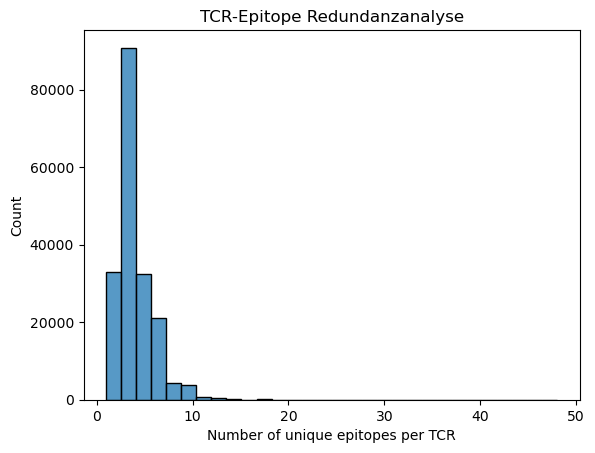

,TRB_CDR3,unique_epitopes
178583,CSHAGLGVEQF,48
160981,CCASTGSYGYTFGSGTRLTVTF,47
19801,CASRRGDRGPDTQYF,36
133916,CASSVLNTGELFF,33
132933,CASSVGLYSTDTQYF,32
85547,CASSPDPTGYNEQFF,29
121302,CASSSIDGNQETQYF,26
119627,CASSSGGVRYEQYF,26
84696,CASSPAGANVLTF,25
89226,CASSPGTGGSEQYF,24


In [5]:
# Häufigkeit, wie oft ein TCR vorkommt – und mit wie vielen unterschiedlichen Epitopen
df_tcr_epitope = train.groupby("TRB_CDR3")["Epitope"].nunique().reset_index()
df_tcr_epitope.columns = ["TRB_CDR3", "unique_epitopes"]

# Verteilung plotten
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_tcr_epitope["unique_epitopes"], bins=30)
plt.xlabel("Number of unique epitopes per TCR")
plt.title("TCR-Epitope Redundanzanalyse")
plt.show()

# Beispiele mit >10 unterschiedlichen Epitopen anzeigen
df_tcr_epitope[df_tcr_epitope["unique_epitopes"] > 10].sort_values("unique_epitopes", ascending=False).head(10)

In [6]:
import pandas as pd

# 1. Daten laden
datasets = {
    "beta_allele": {
        "train": f"{pipeline_data_splitted}/{precision}/beta/train.tsv",
        "test": f"{pipeline_data_splitted}/{precision}/beta/test.tsv",
        "validation": f"{pipeline_data_splitted}/{precision}/beta/validation.tsv"
    }
}

all_dfs = {
    split: pd.read_csv(path, sep="\t")
    for split, path in datasets["beta_allele"].items()
}

# 2. Liste der False-Positive-Paare
fp_pairs = [
    ("CSARGGERFYEQYF", "RYPLTFGWCF"),
    ("CASGLGSYEQYF", "RYPLTFGWCF"),
    ("CASTNSGNTIYF", "RYPLTFGWCF"),
    ("CASEAGNTIYF", "RYPLTFGWCF"),
    ("CASSYDSTTGELFF", "RYPLTFGWCF"),
    ("CSASILGLAGYNEQFF", "RYPLTFGWCF"),
    ("CSASRRETQYF", "RYPLTFGWCF"),
    ("CASSLVAEPSLNTEAFF", "SMDWFQGQM"),
    ("CASSYAQGNEQFF", "TPQDLNTML"),
    ("CASSEREWDEQFF", "TPQDLNTML"),
    ("CASTGQLYGYTF", "TPQDLNTML"),
    ("CASSYLPGQGDHYSNQPQHF", "KPYSGTAYNAL"),
    ("CASSLVLYNEQFF", "TPQDLNTML"),
    ("CASSSEAASSYEQYF", "KPYSGTAYNAL"),
    ("CASSSQADTQYF", "TPQDLNTML"),
    ("CASSPVVLGAGYGYTF", "TPQDLNTML"),
    ("CASSYPEAYGYTF", "TPQDLNTML"),
    ("CATSSGSSYEQYF", "TPQDLNTML"),
    ("CASSYSEDQPQHF", "KPYSGTAYNAL"),
    ("CASSWTQGDEQYF", "TPQDLNTML"),
]

# 3. Suche nach diesen Paaren in allen Splits
for split_name, df in all_dfs.items():
    print(f"\n🔍 Split: {split_name.upper()}")
    df_match = df[df[["TRB_CDR3", "Epitope"]].apply(tuple, axis=1).isin(fp_pairs)]
    if df_match.empty:
        print("Keine Matches gefunden.")
    else:
        print(df_match[["TRB_CDR3", "Epitope", "Binding", "source"]])


/tmp/ipykernel_12850/4029471944.py:13: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  split: pd.read_csv(path, sep="\t")



🔍 Split: TRAIN
Keine Matches gefunden.

🔍 Split: TEST
                   TRB_CDR3      Epitope  Binding     source
332           CASSYSEDQPQHF  KPYSGTAYNAL        0  generated
527    CASSYLPGQGDHYSNQPQHF  KPYSGTAYNAL        0  generated
1081      CASSLVAEPSLNTEAFF    SMDWFQGQM        0  generated
1165        CASSSEAASSYEQYF  KPYSGTAYNAL        0  generated
17955         CASSYPEAYGYTF    TPQDLNTML        0  generated
18257          CASSSQADTQYF    TPQDLNTML        0  generated
20222          CASGLGSYEQYF   RYPLTFGWCF        0  generated
27914        CASSYDSTTGELFF   RYPLTFGWCF        0  generated
31120         CASSWTQGDEQYF    TPQDLNTML        0  generated
31693         CASSLVLYNEQFF    TPQDLNTML        0  generated
34399         CASSYAQGNEQFF    TPQDLNTML        0  generated
35164           CASEAGNTIYF   RYPLTFGWCF        0  generated
37769          CASTNSGNTIYF   RYPLTFGWCF        0  generated
38947      CASSPVVLGAGYGYTF    TPQDLNTML        0  generated
40596         CATSSGSSYEQYF   

In [5]:
frequent_epitopes = [
    "CINGVCWTV", "GTSGSPIVNR", "GTSGSPIINR", "KLGGALQAK", "LLLGIGILV",
    "NLVPMVATV", "KRWIILGLNK", "GILGFVFTL", "GTSGSPIIDK", "EIYKRWII"
]

for split_name, df in all_dfs.items():
    print(f"\n📊 Häufige Epitope im Split: {split_name.upper()}")
    df_epitope = df[df["Epitope"].isin(frequent_epitopes)]
    print(df_epitope[["Epitope", "TRB_CDR3", "Binding", "source"]].head(10))



📊 Häufige Epitope im Split: TRAIN
      Epitope            TRB_CDR3  Binding     source
27  NLVPMVATV    CASSRGTGPFSYEQYF        1   datasets
40  NLVPMVATV     CASSLVPGDAYGYTF        0  generated
54  GILGFVFTL  CASSLSWSSDSLYNEQFF        0  generated
59  NLVPMVATV        CASRSDSGELFF        0        10X
69  NLVPMVATV     CASSIGMGVTYEQYF        0  generated
76  GILGFVFTL     CASSDSSGGTDTQYF        1   datasets
82  KLGGALQAK       CATSMTSGRQQFF        0  generated
83  NLVPMVATV       CASSVFRNYGYTF        0  generated
90  GILGFVFTL    CASSYSSGYLAYEQYF        0        10X
93  NLVPMVATV     CASSPWPEPNTEAFF        1   datasets

📊 Häufige Epitope im Split: TEST
        Epitope           TRB_CDR3  Binding    source
1473   EIYKRWII       CASSYGGTEAFF        1  datasets
1474  KLGGALQAK      CASSLQGYNEQFF        1  datasets
1478  GILGFVFTL   CASSPLQGANTGELFF        1  datasets
1480  GILGFVFTL       CASSDPGNTQYF        1  datasets
1482  KLGGALQAK    CASSSPAEGGQPQHF        1  datasets
1484  KLGGALQ

In [9]:
frequent_epitopes = [
    "KPYSGTAYNAL", "TPQDLNTML", "RYPLTFGWCF"
]

for split_name, df in all_dfs.items():
    print(f"\n📊 Häufige Epitope im Split: {split_name.upper()}")
    df_epitope = df[df["Epitope"].isin(frequent_epitopes)]
    print(df_epitope[["Epitope", "TRB_CDR3", "Binding", "source"]].head(10))



📊 Häufige Epitope im Split: TRAIN
           Epitope            TRB_CDR3  Binding     source
5426    RYPLTFGWCF    CASSPGSGELGAGELF        1   datasets
19999   RYPLTFGWCF    CASLPSVGKGAYEQYF        1   datasets
44088   RYPLTFGWCF    CASSYSHRLGLHEQYF        1   datasets
51306   RYPLTFGWCF  CASSYSIGTGVNNYGYTF        1   datasets
74788   RYPLTFGWCF    CASSPHLRKGLEPQHF        1   datasets
93236   RYPLTFGWCF     CASSDFGTGMNEQYF        1   datasets
112613  RYPLTFGWCF       CASSSKWRNTQYF        1   datasets
150464  RYPLTFGWCF       CASSLDYPYEQYF        0  generated
164979  RYPLTFGWCF        CASKGTVTGELF        1   datasets
175442  RYPLTFGWCF    CASSLRPGRANTGELF        1   datasets

📊 Häufige Epitope im Split: TEST
          Epitope              TRB_CDR3  Binding     source
30    KPYSGTAYNAL         CAINPGTAYGYTF        1   datasets
211   KPYSGTAYNAL          CASSPGTPEQFF        1   datasets
332   KPYSGTAYNAL         CASSYSEDQPQHF        0  generated
395   KPYSGTAYNAL      CASSAPDYSAYNEQFF   

In [8]:
import pandas as pd

# CSV laden
false_positives_sorted = pd.read_csv("../../results/false_positives.csv", sep="\t")

# Gruppenstatistik
fp_scores_by_epitope = false_positives_sorted.groupby("Epitope")["score"].agg(["mean", "std", "count"]).sort_values("mean", ascending=False)

# Top-10 aus deiner Analyse
top_confused = [
    "CINGVCWTV", "GTSGSPIVNR", "GTSGSPIINR", "KLGGALQAK", "LLLGIGILV",
    "NLVPMVATV", "KRWIILGLNK", "GILGFVFTL", "GTSGSPIIDK", "EIYKRWII"
]

# Nur die interessanten anzeigen
print(fp_scores_by_epitope.loc[top_confused])


                mean       std  count
Epitope                              
CINGVCWTV   0.997297  0.003001   3464
GTSGSPIVNR  0.996511  0.002893   2286
GTSGSPIINR  0.998241  0.000243   2202
KLGGALQAK   0.657638  0.109792   1878
LLLGIGILV   0.764528  0.134982   1744
NLVPMVATV   0.895710  0.012930   1592
KRWIILGLNK  0.998117  0.000871   1420
GILGFVFTL   0.799367  0.038058   1149
GTSGSPIIDK  0.997479  0.000545    983
EIYKRWII    0.998022  0.000725    879


In [11]:
import pandas as pd

# Deine Top-FP-Epitope
top_fp_epitopes = [
    "CINGVCWTV", "GTSGSPIVNR", "GTSGSPIINR", "KLGGALQAK", "LLLGIGILV",
    "NLVPMVATV", "KRWIILGLNK", "GILGFVFTL", "GTSGSPIIDK", "EIYKRWII", "KPYSGTAYNAL", "TPQDLNTML", "RYPLTFGWCF"
]

# Lade deine Splits (ggf. Pfade anpassen)
train_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/train.tsv", sep="\t")
val_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/validation.tsv", sep="\t")
test_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/test.tsv", sep="\t")

# Funktion: zählt Binding-Verteilung je Epitope im gegebenen Split
def count_binding_occurrences(df, split_name):
    counts = df[df["Epitope"].isin(top_fp_epitopes)] \
        .groupby(["Epitope", "Binding"]) \
        .size() \
        .unstack(fill_value=0)
    counts.columns = ["Not Binding (0)", "Binding (1)"]
    print(f"\n📊 Verteilung im Split: {split_name}")
    print(counts)

# Anwenden auf alle Splits
count_binding_occurrences(train_df, "TRAIN")
count_binding_occurrences(val_df, "VALIDATION")
count_binding_occurrences(test_df, "TEST")


/tmp/ipykernel_97932/646486496.py:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  val_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/validation.tsv", sep="\t")



📊 Verteilung im Split: TRAIN
            Not Binding (0)  Binding (1)
Epitope                                 
CINGVCWTV                12           85
EIYKRWII                  1           35
GILGFVFTL             20590         4963
GTSGSPIIDK                1            2
GTSGSPIINR                1            3
GTSGSPIVNR                1            2
KLGGALQAK             10046          750
KRWIILGLNK                2           96
LLLGIGILV                 1            0
NLVPMVATV             12725         4714
RYPLTFGWCF                1           37
TPQDLNTML                 1            0

📊 Verteilung im Split: VALIDATION
            Not Binding (0)  Binding (1)
Epitope                                 
CINGVCWTV               661           24
EIYKRWII                  0            1
GILGFVFTL             10705         1249
GTSGSPIIDK                0            2
GTSGSPIINR                3            7
GTSGSPIVNR                1            4
KLGGALQAK              8037      

In [7]:
import random
import os
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, precision_score, recall_score, average_precision_score, roc_curve, log_loss
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import wandb
import yaml
import sys
import seaborn as sns
import io
from sklearn.calibration import calibration_curve
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append(os.path.abspath("../../"))

from models.morning_stars_v1.beta.v3_mha_1024_res_php_pe import TCR_Epitope_Transformer, LazyTCR_Epitope_Descriptor_Dataset

import h5py
sys.path.append(os.path.abspath('../'))
from utils.arg_parser import parse_args

# Embedding-Pfade
tcr_test_path = "../../../../data/embeddings/beta/allele/dimension_1024/padded_test_tcr_embeddings_final.h5"
epitope_test_path = "../../../../data/embeddings/beta/allele/dimension_1024/padded_test_epitope_embeddings_final.h5"
physchem_path = "../../../../data/physico/descriptor_encoded_physchem.h5"

# Lade deine Splits (ggf. Pfade anpassen)
train_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/train.tsv", sep="\t")
val_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/validation.tsv", sep="\t")
test_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/test.tsv", sep="\t")

# Embeddings lazy laden
tcr_test_embeddings = h5py.File(tcr_test_path, 'r')
epitope_test_embeddings = h5py.File(epitope_test_path, 'r')
physchem_file = h5py.File(physchem_path, 'r')

from types import SimpleNamespace

args = SimpleNamespace(
    configs_path="../../configs/v3_mha_1024_config.yaml",  # oder dein Pfad
    tcr_test_embeddings="../data/embeddings/beta/allele/dimension_1024/padded_test_tcr_embeddings_final.h5",
    epitope_test_embeddings="../data/embeddings/beta/allele/dimension_1024/padded_test_epitope_embeddings_final.h5"
    # optional weitere Felder je nach Bedarf hinzufügen
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lade echte False Positives
false_positives = pd.read_csv("../../results/false_positives.csv", sep="\t")

# Ersetze TCR_CDR3 durch zufälligen aus dem Testset
all_tcrs = test_df["TRB_CDR3"].unique()
random_tcrs = [random.choice(all_tcrs) for _ in range(len(false_positives))]
false_positives_randomized = false_positives.copy()
false_positives_randomized["TRB_CDR3"] = random_tcrs

# Optional: Gleiche physchem_index updaten
# (Wenn du nicht lazy lädst, musst du ggf. Embeddings neu mappen)

# Neuen Dataset und Loader erzeugen
fp_random_ds = LazyTCR_Epitope_Descriptor_Dataset(false_positives_randomized, tcr_test_embeddings, epitope_test_embeddings, physchem_file)
fp_random_loader = DataLoader(fp_random_ds, batch_size=64)

# Lade Konfiguration aus YAML
with open(args.configs_path, "r") as f:
    config = yaml.safe_load(f)
with h5py.File(physchem_path, 'r') as f:
    inferred_physchem_dim = f["tcr_encoded"].shape[1]
    
model = TCR_Epitope_Transformer(
    config['embed_dim'],
    config['num_heads'],
    config['num_layers'],
    config['max_tcr_length'],
    config['max_epitope_length'],
    dropout=config.get('dropout', 0.1),
    classifier_hidden_dim=config.get('classifier_hidden_dim', 64),
    physchem_dim=inferred_physchem_dim  
).to(device)

# Modell erneut befragen
random_scores = []
model.eval()
with torch.no_grad():
    for tcr, epitope, tcr_phys, epi_phys, _ in fp_random_loader:
        tcr, epitope, tcr_phys, epi_phys = [x.to(device) for x in (tcr, epitope, tcr_phys, epi_phys)]
        output = model(tcr, epitope, tcr_phys, epi_phys)
        probs = torch.sigmoid(output).cpu().numpy()
        random_scores.extend(probs)

# Ergebnis vergleichen
false_positives_randomized["random_score"] = random_scores

# ⏬ Score-Drop analysieren
comparison = false_positives[["TRB_CDR3", "Epitope", "score"]].copy()
comparison["random_score"] = random_scores
comparison["drop"] = comparison["score"] - comparison["random_score"]
print(comparison.sort_values("drop", ascending=False).head(10))

/tmp/ipykernel_12850/4252448786.py:37: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  val_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/validation.tsv", sep="\t")


              TRB_CDR3     Epitope     score  random_score      drop
5659      CASSWDRNEQFF   CINGVCWTV  0.998319      0.364457  0.633862
589     CASSLGGFGSPLHF  KLVALGINAV  0.998749      0.366618  0.632132
1529  CANNPSWAYSNQPQHF  RYPLTFGWCF  0.998604      0.368237  0.630367
341      CASGPGQGNGYTF  RYPLTFGWCF  0.998817      0.368840  0.629977
984         CASSLGGLHF  KRWIILGLNK  0.998674      0.368738  0.629936
2765       CASSLHHEQYF   CINGVCWTV  0.998502      0.368738  0.629764
9473  CASSFGELPYNSPLHF  EAAGIGILTV  0.998046      0.369163  0.628883
3251   CASSTQVIGNQPQHF  KLVALGINAV  0.998468      0.369668  0.628799
139     CASSFSDFGNEQYF  RYPLTFGWCF  0.998904      0.370319  0.628585
6560    CSAHWGLESSPLHF  KRWIILGLNK  0.998258      0.369685  0.628574


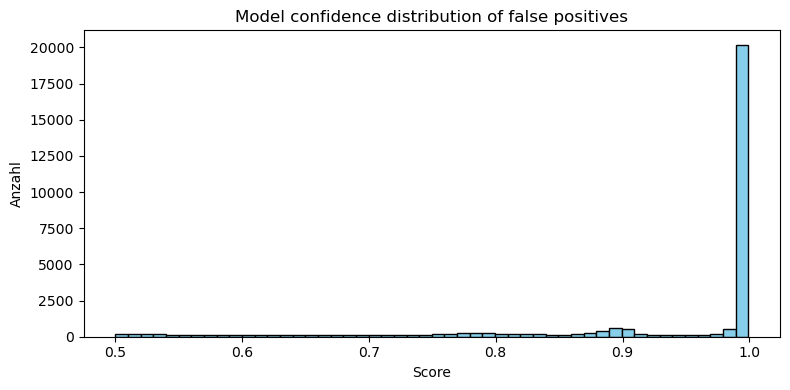

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

fp = pd.read_csv("../../results/false_positives.csv", sep="\t")

# Häufigste Epitope
epitope_counts = fp["Epitope"].value_counts().head(10)

plt.figure(figsize=(8, 4))
plt.hist(fp["score"], bins=50, color="skyblue", edgecolor="black")
plt.title("Model confidence distribution of false positives")
plt.xlabel("Score")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

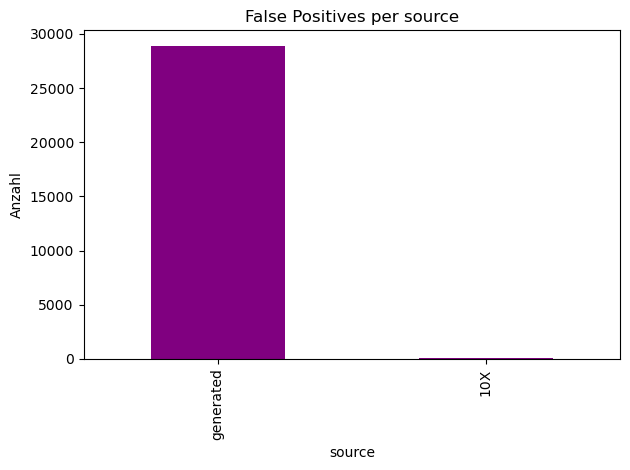

In [19]:
source_counts = fp["source"].value_counts()

source_counts.plot(kind="bar", color="purple")
plt.title("False Positives per source")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

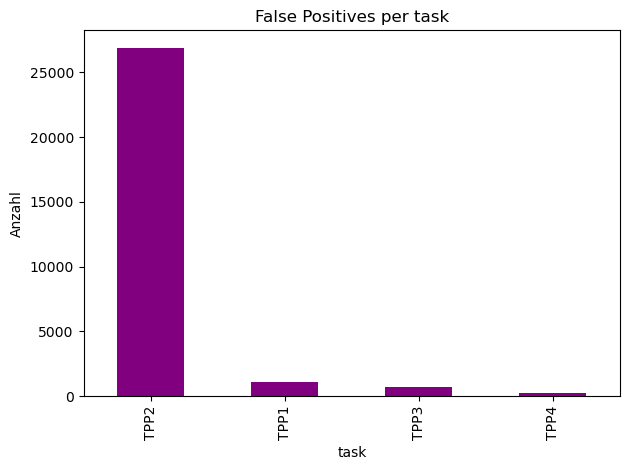

In [21]:
task_counts = fp["task"].value_counts()

task_counts.plot(kind="bar", color="purple")
plt.title("False Positives per task")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()

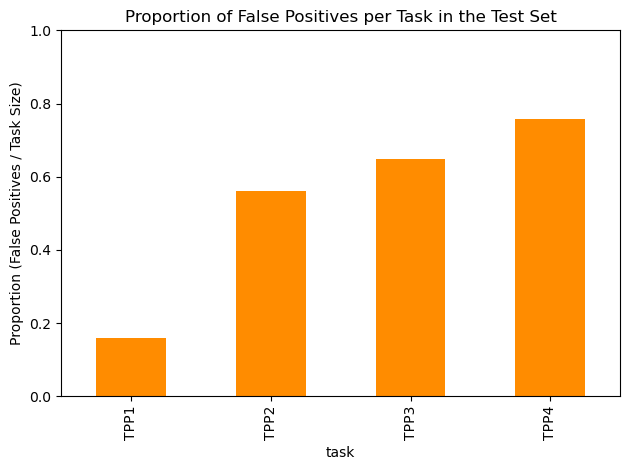

In [24]:
# 1. False Positives pro Task
fp_task_counts = fp["task"].value_counts()

# 2. Alle Testbeispiele pro Task (aus df_test)
test_task_counts = test_df["task"].value_counts()

# 3. Verhältnis: FP-Anteil pro Task
fp_ratio = (fp_task_counts / test_task_counts).sort_index()

# 4. Visualisieren
fp_ratio.plot(kind="bar", color="darkorange")
plt.title("Proportion of False Positives per Task in the Test Set")
plt.ylabel("Proportion (False Positives / Task Size)")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

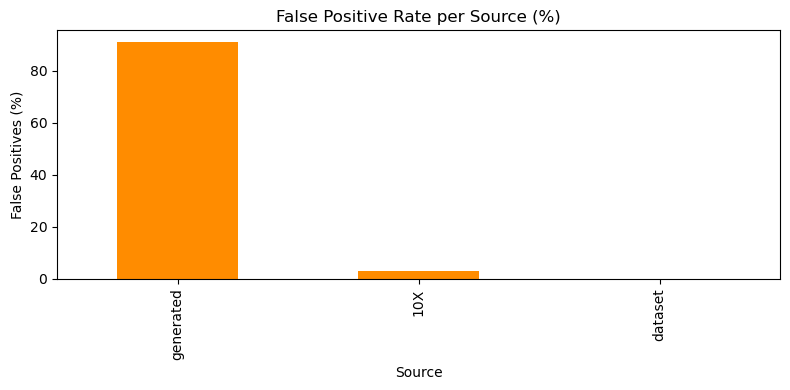

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Einlesen
fp = pd.read_csv("../../results/false_positives.csv", sep="\t")
test_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/test.tsv", sep="\t")

# Gesamtanzahl pro Quelle im gesamten Testset
total_per_source = test_df["source"].value_counts()

# Anzahl der False Positives pro Quelle
fp_per_source = fp["source"].value_counts()

# Prozentuale False Positive Rate pro Quelle
fp_rate_per_source = (fp_per_source / total_per_source * 100).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 4))
fp_rate_per_source.plot(kind="bar", color="darkorange")
plt.title("False Positive Rate per Source (%)")
plt.ylabel("False Positives (%)")
plt.xlabel("Source")
plt.tight_layout()
plt.show()


# Datenanalyse mit neuen Daten am 12.05.

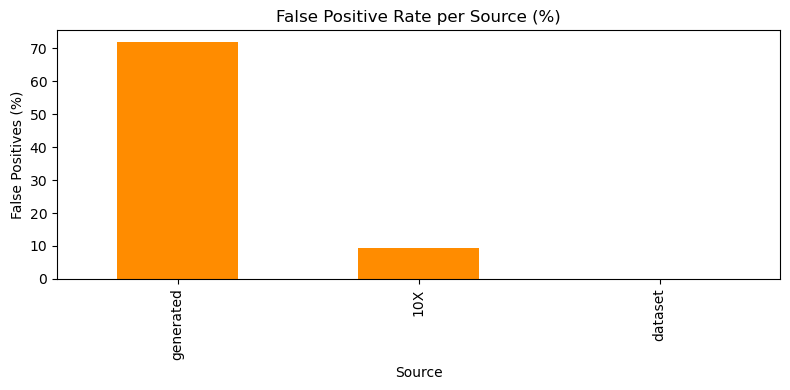

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Einlesen
fp = pd.read_csv("../../results/false_positives_v1oversample.csv", sep="\t")
test_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/test.tsv", sep="\t")

# Gesamtanzahl pro Quelle im gesamten Testset
total_per_source = test_df["source"].value_counts()

# Anzahl der False Positives pro Quelle
fp_per_source = fp["source"].value_counts()

# Prozentuale False Positive Rate pro Quelle
fp_rate_per_source = (fp_per_source / total_per_source * 100).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 4))
fp_rate_per_source.plot(kind="bar", color="darkorange")
plt.title("False Positive Rate per Source (%)")
plt.ylabel("False Positives (%)")
plt.xlabel("Source")
plt.tight_layout()
plt.show()

Anzahl TPP2 False Positives: 17237


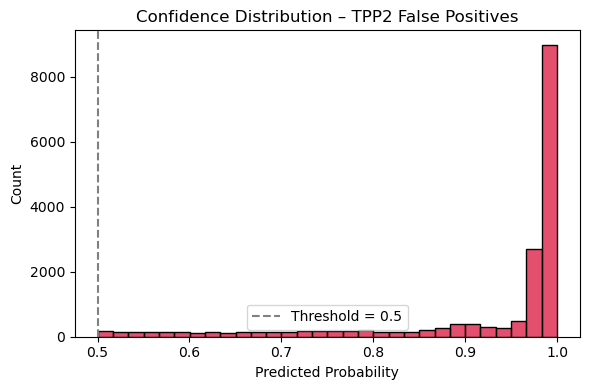


Top Epitope unter TPP2-False-Positives:
 Epitope
CINGVCWTV     2242
GTSGSPIINR    1409
GTSGSPIVNR    1385
KLGGALQAK     1106
KRWIILGLNK    1079
NLVPMVATV     1065
GILGFVFTL      880
GLCTLVAML      767
EIYKRWII       654
FLKEKGGL       601
Name: count, dtype: int64


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV einlesen
fp = pd.read_csv("../../results/false_positives_v1oversample.csv", sep="\t")

# Nur TPP2-Fehlklassifikationen
fp_tpp2 = fp[fp["task"] == "TPP2"].copy()
print(f"Anzahl TPP2 False Positives: {len(fp_tpp2)}")

# Confidence Score Verteilung
plt.figure(figsize=(6,4))
sns.histplot(fp_tpp2["predicted_score"], bins=30, color="crimson", edgecolor="black")
plt.title("Confidence Distribution – TPP2 False Positives")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.axvline(0.5, linestyle="--", color="gray", label="Threshold = 0.5")
plt.legend()
plt.tight_layout()
plt.savefig("results/tpp2_fp_confidence_hist.png")
plt.show()

# Top Epitope bei FPs
top_epitopes = fp_tpp2["Epitope"].value_counts().head(10)
print("\nTop Epitope unter TPP2-False-Positives:\n", top_epitopes)

In [24]:
import pandas as pd

# 1. Liste deiner Epitope
fp_epitopes = [
    "CINGVCWTV", "GTSGSPIINR", "GTSGSPIVNR", "KLGGALQAK", "KRWIILGLNK",
    "NLVPMVATV"]

# 2. Trainingsdaten laden
train_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/train.tsv", sep="\t")

# 3. Nur negative Bindungen mit diesen Epitope
negatives_with_epitope = train_df[
    (train_df["Epitope"].isin(fp_epitopes)) &
    (train_df["Binding"] == 0)
]

# 4. Auswertung
counts = negatives_with_epitope["Epitope"].value_counts()
print("\nNegative Bindungen im Training für diese Epitope:")
print(counts)

# Optional: Epitope ohne *jede* negative Instanz
epitopes_with_no_negatives = [e for e in fp_epitopes if e not in counts]
print("\nDiese Epitope hatten KEINE negativen Bindungen im Training:")
print(epitopes_with_no_negatives)


Negative Bindungen im Training für diese Epitope:
Epitope
NLVPMVATV     15912
KLGGALQAK      7394
CINGVCWTV        38
KRWIILGLNK       14
GTSGSPIVNR        1
GTSGSPIINR        1
Name: count, dtype: int64

Diese Epitope hatten KEINE negativen Bindungen im Training:
[]


In [16]:
# Top Epitope bei FPs
top_epitopes = fp_tpp2["TRB_CDR3"].value_counts().head(10)
print("\nTop Epitope unter TPP2-False-Positives:\n", top_epitopes)


Top Epitope unter TPP2-False-Positives:
 TRB_CDR3
CASSYRGGRAGETQYF    9
CATSDNNVWFSEQFF     9
CASSFDGVYEQYF       9
CASSAGSGNEQYF       9
CASSLGQGLLYGYTF     9
CASSQGLAGAGELFF     9
CASSLGGGLQETQYF     8
CASSLGLEGEQYF       8
CASSLGPEKEQFF       8
CASSFGAGSQETQYF     8
Name: count, dtype: int64


In [30]:
#####TPP2 >> wenig Epitope künstlich vergrössern mit negativen Beispielen
train_df = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/train.tsv", sep="\t")

# Liste mit zu wenig negativen Beispielen
rare_epitopes = ["CINGVCWTV", "GTSGSPIINR", "GTSGSPIVNR"]

augmented = []
for epitope in rare_epitopes:
    used_tcrs = train_df[train_df["Epitope"] == epitope]["TRB_CDR3"].unique()
    candidate_tcrs = train_df[~train_df["TRB_CDR3"].isin(used_tcrs)]["TRB_CDR3"].unique()

    num_to_generate = 1000  
    sampled = np.random.choice(candidate_tcrs, size=num_to_generate, replace=False)

    df = pd.DataFrame({
        "TRB_CDR3": sampled,
        "Epitope": [epitope] * num_to_generate,
        "Binding": [0] * num_to_generate,
        "source": ["augmented"] * num_to_generate
    })

    augmented.append(df)

augmented_negatives = pd.concat(augmented, ignore_index=True)
augmented_negatives.to_csv("augmented_negatives_tpp2.tsv", sep="\t", index=False)
print("✅ Speichern abgeschlossen.")


✅ Speichern abgeschlossen.


In [35]:
import pandas as pd

# Lade augmentierte negative Beispiele
aug_neg = pd.read_csv("augmented_negatives_tpp2.tsv", sep="\t")

# Lade originale Datasets
train = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/train.tsv", sep="\t")
val   = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/validation.tsv", sep="\t")
test  = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/test.tsv", sep="\t")

# Nur positive Bindungen aus allen Splits
pos_train = train[train["Binding"] == 1]
pos_val = val[val["Binding"] == 1]
pos_test = test[test["Binding"] == 1]

# Kombiniere alle positiven Paare
positive_pairs = pd.concat([pos_train, pos_val, pos_test])[["TRB_CDR3", "Epitope"]].drop_duplicates()

# Prüfe Überschneidung
merged = aug_neg.merge(positive_pairs, on=["TRB_CDR3", "Epitope"], how="inner")

# Ergebnis anzeigen
print(f"⚠️ {len(merged)} augmentierte Negative kommen auch als Positive im Dataset vor!")
if not merged.empty:
    print(merged.head())

/tmp/ipykernel_21340/1019784861.py:8: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  val   = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/validation.tsv", sep="\t")


⚠️ 0 augmentierte Negative kommen auch als Positive im Dataset vor!


In [34]:
# Augmentierte Daten laden
aug_file = "augmented_negatives_tpp2.tsv"
aug_df = pd.read_csv(aug_file, sep="\t")

# Train/Val/Test einlesen
train = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/train.tsv", sep="\t")
val = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/validation.tsv", sep="\t")
test = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/test.tsv", sep="\t")

# Kombiniere positive Bindungen aus allen Splits
all_pos = pd.concat([train, val, test])
all_pos = all_pos[all_pos["Binding"] == 1][["TRB_CDR3", "Epitope"]]

# Entferne augmentierte Paare, die auch als positive vorkommen
cleaned_aug_df = pd.merge(aug_df, all_pos, on=["TRB_CDR3", "Epitope"], how="left", indicator=True)
cleaned_aug_df = cleaned_aug_df[cleaned_aug_df["_merge"] == "left_only"].drop(columns="_merge")

# Speichern
cleaned_aug_df.to_csv("augmented_negatives_tpp2.tsv", sep="\t", index=False)
print(f"✅ Gesäubert gespeichert: {len(cleaned_aug_df)} Einträge verbleiben.")

/tmp/ipykernel_21340/899999213.py:7: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  val = pd.read_csv(f"{pipeline_data_splitted}/{precision}/beta/validation.tsv", sep="\t")


✅ Gesäubert gespeichert: 2997 Einträge verbleiben.


In [26]:
import pandas as pd

# --- Lade Validation und Test ---
val_path = f"{pipeline_data_splitted}/{precision}/beta/new/validation.tsv"
test_path = f"{pipeline_data_splitted}/{precision}/beta/new/test.tsv"

val_df = pd.read_csv(val_path, sep='\t')
test_df = pd.read_csv(test_path, sep='\t')

# --- Duplikate auf ("TCR_CDR3", "Epitope", "Binding") finden ---
val_duplicates = val_df[val_df.duplicated(subset=["TRB_CDR3", "Epitope", "Binding"], keep=False)]
test_duplicates = test_df[test_df.duplicated(subset=["TRB_CDR3", "Epitope", "Binding"], keep=False)]

# --- Gruppieren nach Task ---
print("\n📊 Duplikate nach Task in Validation:")
print(val_duplicates['task'].value_counts())

print("\n📊 Duplikate nach Task in Test:")
print(test_duplicates['task'].value_counts())



📊 Duplikate nach Task in Validation:
task
TPP1    88
TPP3    52
Name: count, dtype: int64

📊 Duplikate nach Task in Test:
task
TPP3    28
TPP1    25
TPP4     2
Name: count, dtype: int64


/tmp/ipykernel_130246/142913063.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  val_df = pd.read_csv(val_path, sep='\t')


In [25]:
import pandas as pd

# --- Test laden ---
test_path = f"{pipeline_data_splitted}/{precision}/beta/new/test.tsv"
test_df = pd.read_csv(test_path, sep='\t')

# --- Nur TPP2 herausfiltern ---
tpp2_test = test_df[test_df['task'] == 'TPP2']
other_test = test_df[test_df['task'] != 'TPP2']

# --- Duplikate innerhalb TPP2 finden ---
tpp2_duplicates = tpp2_test.duplicated(subset=["TRB_CDR3", "Epitope", "Binding"], keep='first')

# --- Nur einmalige TPP2 behalten (erste Vorkommen) ---
tpp2_test_cleaned = tpp2_test[~tpp2_duplicates]

print(f"✅ Alte TPP2 im Test: {len(tpp2_test)}")
print(f"✅ Neue TPP2 im Test nach Entfernen von Duplikaten: {len(tpp2_test_cleaned)}")

# --- Neues Testset zusammensetzen ---
test_df_cleaned = pd.concat([other_test, tpp2_test_cleaned], ignore_index=True)

# --- Speichern ---
test_df_cleaned.to_csv(test_path, sep='\t', index=False)

print("✅ Testset erfolgreich aktualisiert (TPP2-Duplikate entfernt).")


✅ Alte TPP2 im Test: 47912
✅ Neue TPP2 im Test nach Entfernen von Duplikaten: 47912
✅ Testset erfolgreich aktualisiert (TPP2-Duplikate entfernt).


In [24]:
import pandas as pd

# --- Validation laden ---
val_path = f"{pipeline_data_splitted}/{precision}/beta/new/validation.tsv"
val_df = pd.read_csv(val_path, sep='\t')

# --- Nur TPP2 herausfiltern ---
tpp2_val = val_df[val_df['task'] == 'TPP2']
other_val = val_df[val_df['task'] != 'TPP2']

# --- Duplikate innerhalb TPP2 finden ---
tpp2_duplicates_val = tpp2_val.duplicated(subset=["TRB_CDR3", "Epitope", "Binding"], keep='first')

# --- Nur einmalige TPP2 behalten (erste Vorkommen) ---
tpp2_val_cleaned = tpp2_val[~tpp2_duplicates_val]

print(f"✅ Alte TPP2 in Validation: {len(tpp2_val)}")
print(f"✅ Neue TPP2 in Validation nach Entfernen von Duplikaten: {len(tpp2_val_cleaned)}")

# --- Neues Validation-Set zusammensetzen ---
val_df_cleaned = pd.concat([other_val, tpp2_val_cleaned], ignore_index=True)

# --- Speichern ---
val_df_cleaned.to_csv(val_path, sep='\t', index=False)

print("✅ Validation-Set erfolgreich aktualisiert (TPP2-Duplikate entfernt).")

/tmp/ipykernel_130246/2665809561.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  val_df = pd.read_csv(val_path, sep='\t')


✅ Alte TPP2 in Validation: 102377
✅ Neue TPP2 in Validation nach Entfernen von Duplikaten: 102377
✅ Validation-Set erfolgreich aktualisiert (TPP2-Duplikate entfernt).


In [28]:
import pandas as pd

train_file = f'{pipeline_data_splitted}/{precision}/beta/new/train.tsv'
validation_file = f'{pipeline_data_splitted}/{precision}/beta/new/validation.tsv'
test_file = f'{pipeline_data_splitted}/{precision}/beta/new/test.tsv'

# Dateien einlesen
train_df = pd.read_csv(train_file, sep='\t')
val_df = pd.read_csv(validation_file, sep='\t')
test_df = pd.read_csv(test_file, sep='\t')

# Funktion zur Ausgabe der Verteilung
def show_binding_distribution(df, name):
    counts = df['Binding'].value_counts().sort_index()
    total = counts.sum()
    print(f'--- {name} ---')
    for b in counts.index:
        percentage = (counts[b] / total) * 100
        print(f'Binding = {b}: {counts[b]} Beispiele ({percentage:.2f}%)')
    print(f'Total: {total} Beispiele\n')

# Ausgabe
show_binding_distribution(train_df, 'Train')
show_binding_distribution(val_df, 'Validation')
show_binding_distribution(test_df, 'Test')

--- Train ---
Binding = 0: 623204 Beispiele (83.13%)
Binding = 1: 126463 Beispiele (16.87%)
Total: 749667 Beispiele

--- Validation ---
Binding = 0: 157347 Beispiele (84.16%)
Binding = 1: 29604 Beispiele (15.84%)
Total: 186951 Beispiele

--- Test ---
Binding = 0: 47434 Beispiele (84.01%)
Binding = 1: 9026 Beispiele (15.99%)
Total: 56460 Beispiele



/tmp/ipykernel_130246/3626647992.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  val_df = pd.read_csv(validation_file, sep='\t')


In [9]:
import pandas as pd

# Lade die test.tsv Datei
df = pd.read_csv(f'{pipeline_data_splitted}/{precision}/beta/test.tsv', sep='\t')

# Annahme: Es gibt eine Spalte 'task' und eine Spalte 'tcr'
# Falls die Spalten anders heißen, bitte anpassen!

# Gruppiere nach 'task' und zähle die einzigartigen TCRs
unique_tcr_per_task = df.groupby('task')['TRB_CDR3'].nunique()
unique_epitop_per_task = df.groupby('task')['Epitope'].nunique()

# Ausgabe
print(unique_tcr_per_task)
print(unique_epitop_per_task)


task
TPP1    6676
TPP2    7317
TPP3     292
TPP4     153
Name: TRB_CDR3, dtype: int64
task
TPP1    215
TPP2    175
TPP3     94
TPP4     73
Name: Epitope, dtype: int64


In [5]:
# Definierte Pfade für alle vier Kategorien
datasets = {
    "beta_allele": {
        "test": f'{pipeline_data_splitted}/{precision}/beta/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
    }
}

In [6]:
# Definierte Pfade für alle vier Kategorien
datasets = {
    "beta_allele": {
        "test": f'{pipeline_data_splitted}/{precision}/beta/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
    }
}
# Analyse-Funktion
def analyze_binding_distribution(file_path):
    df = pd.read_csv(file_path, sep='\t')

    # Spaltennamen vereinheitlichen
    df.columns = [col.lower() for col in df.columns]

    if 'binding' not in df.columns or 'task' not in df.columns:
        raise ValueError(f"'binding' oder 'task' Spalte fehlt in {file_path}")

    # Gruppieren nach task und binding
    stats = df.groupby(['task', 'binding']).size().unstack(fill_value=0)

    # Spalten konsistent benennen (wenn z.B. nur 0 oder nur 1 vorkommt)
    if 0 in stats.columns and 1 in stats.columns:
        stats.columns = ['Non-Binder', 'Binder']
    elif 0 in stats.columns:
        stats['Binder'] = 0
        stats.columns = ['Non-Binder', 'Binder']
    elif 1 in stats.columns:
        stats['Non-Binder'] = 0
        stats.columns = ['Binder', 'Non-Binder']
    else:
        raise ValueError("Keine Binder/Non-Binder-Werte gefunden")

    # Berechnungen
    stats['Total'] = stats.sum(axis=1)
    stats['Binder %'] = (stats['Binder'] / stats['Total'] * 100).round(2)
    stats['Non-Binder %'] = (stats['Non-Binder'] / stats['Total'] * 100).round(2)

    return stats

# Alle Splits durchgehen
for dataset_name, splits in datasets.items():
    print(f"\n### Dataset: {dataset_name} ###")
    for split_name, path in splits.items():
        if os.path.exists(path):
            print(f"\n--- {split_name.upper()} ---")
            stats = analyze_binding_distribution(path)
            print(stats)
        else:
            print(f"{split_name} not found: {path}")


### Dataset: beta_allele ###

--- TEST ---
      Non-Binder  Binder  Total  Binder %  Non-Binder %
task                                                   
TPP1        5873    1203   7076     17.00         83.00
TPP2       40399    7513  47912     15.68         84.32
TPP3         881     258   1139     22.65         77.35
TPP4         281      52    333     15.62         84.38

--- VALIDATION ---
      Non-Binder  Binder   Total  Binder %  Non-Binder %
task                                                    
TPP1       62767   12856   75623     17.00         83.00
TPP2       87410   14967  102377     14.62         85.38
TPP3        6976    1744    8720     20.00         80.00
TPP4         194      37     231     16.02         83.98


/tmp/ipykernel_124091/3887706011.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep='\t')


In [ ]:
import pandas as pd

# Beispielpfad (ersetze durch deine Variable bei Bedarf)
test_path = datasets["beta_allele"]["test"]

# Lade das Test-TSV
df = pd.read_csv(test_path, sep='\t')

# Wieviele Zeilen hat die Datei insgesamt?
print(f"Anzahl Zeilen im Testset: {len(df)}")

# Duplikate anhand von TCR + Epitope + Binding (exakt gleiches Beispiel)
duplicates = df[df.duplicated(subset=["TRB_CDR3", "Epitope", "Binding"], keep=False)]

# Ausgabe: alle Duplikate
print(f"\nGesamtanzahl an Duplikaten: {len(duplicates)}")

# Gruppiert nach Bindungsklasse
dup_counts = duplicates.groupby("Binding").size()
print("\nAnzahl Duplikate pro Binding-Klasse:")
print(dup_counts)

# Optional: doppelte Kombinationen anzeigen
#print("\nBeispielhafte Duplikate:")
#print(duplicates.sort_values(by=["TRB_CDR3", "Epitope"]).head(10))


In [43]:
# Definierte Pfade für alle vier Kategorien
datasets = {
    "beta_allele": {
        "test": f'{pipeline_data_splitted}/{precision}/beta/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/validation.tsv'
    }
}

In [44]:
# Analyse-Funktion
def analyze_binding_distribution(file_path):
    df = pd.read_csv(file_path, sep='\t')

    # Spaltennamen vereinheitlichen
    df.columns = [col.lower() for col in df.columns]

    if 'binding' not in df.columns or 'task' not in df.columns:
        raise ValueError(f"'binding' oder 'task' Spalte fehlt in {file_path}")

    # Gruppieren nach task und binding
    stats = df.groupby(['task', 'binding']).size().unstack(fill_value=0)

    # Spalten konsistent benennen (wenn z.B. nur 0 oder nur 1 vorkommt)
    if 0 in stats.columns and 1 in stats.columns:
        stats.columns = ['Non-Binder', 'Binder']
    elif 0 in stats.columns:
        stats['Binder'] = 0
        stats.columns = ['Non-Binder', 'Binder']
    elif 1 in stats.columns:
        stats['Non-Binder'] = 0
        stats.columns = ['Binder', 'Non-Binder']
    else:
        raise ValueError("Keine Binder/Non-Binder-Werte gefunden")

    # Berechnungen
    stats['Total'] = stats.sum(axis=1)
    stats['Binder %'] = (stats['Binder'] / stats['Total'] * 100).round(2)
    stats['Non-Binder %'] = (stats['Non-Binder'] / stats['Total'] * 100).round(2)

    return stats

# Alle Splits durchgehen
for dataset_name, splits in datasets.items():
    print(f"\n### Dataset: {dataset_name} ###")
    for split_name, path in splits.items():
        if os.path.exists(path):
            print(f"\n--- {split_name.upper()} ---")
            stats = analyze_binding_distribution(path)
            print(stats)
        else:
            print(f"{split_name} not found: {path}")


### Dataset: beta_allele ###

--- TEST ---
      Non-Binder  Binder  Total  Binder %  Non-Binder %
task                                                   
TPP1       44422    1059  45481      2.33         97.67
TPP2          68    7728   7796     99.13          0.87
TPP3           0      88     88    100.00          0.00
TPP4          10      25     35     71.43         28.57

--- VALIDATION ---
      Non-Binder  Binder   Total  Binder %  Non-Binder %
task                                                    
TPP1      170206   18291  188497      9.70         90.30
TPP2        4634   15207   19841     76.64         23.36
TPP3          36    1509    1545     97.67          2.33
TPP4         284      25     309      8.09         91.91


In [49]:
# Definierte Pfade für alle vier Kategorien
datasets = {
    "beta_allele": {
        "train": f'{pipeline_data_splitted}/{precision}/beta/new/train.tsv',
        "test": f'{pipeline_data_splitted}/{precision}/beta/new/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/new/validation.tsv'
    }
}

In [47]:
# Analyse-Funktion
def analyze_binding_distribution(file_path):
    df = pd.read_csv(file_path, sep='\t')

    # Spaltennamen vereinheitlichen
    df.columns = [col.lower() for col in df.columns]

    if 'binding' not in df.columns or 'task' not in df.columns:
        raise ValueError(f"'binding' oder 'task' Spalte fehlt in {file_path}")

    # Gruppieren nach task und binding
    stats = df.groupby(['task', 'binding']).size().unstack(fill_value=0)

    # Spalten konsistent benennen (wenn z.B. nur 0 oder nur 1 vorkommt)
    if 0 in stats.columns and 1 in stats.columns:
        stats.columns = ['Non-Binder', 'Binder']
    elif 0 in stats.columns:
        stats['Binder'] = 0
        stats.columns = ['Non-Binder', 'Binder']
    elif 1 in stats.columns:
        stats['Non-Binder'] = 0
        stats.columns = ['Binder', 'Non-Binder']
    else:
        raise ValueError("Keine Binder/Non-Binder-Werte gefunden")

    # Berechnungen
    stats['Total'] = stats.sum(axis=1)
    stats['Binder %'] = (stats['Binder'] / stats['Total'] * 100).round(2)
    stats['Non-Binder %'] = (stats['Non-Binder'] / stats['Total'] * 100).round(2)

    return stats

# Alle Splits durchgehen
for dataset_name, splits in datasets.items():
    print(f"\n### Dataset: {dataset_name} ###")
    for split_name, path in splits.items():
        if os.path.exists(path):
            print(f"\n--- {split_name.upper()} ---")
            stats = analyze_binding_distribution(path)
            print(stats)
        else:
            print(f"{split_name} not found: {path}")


### Dataset: beta_allele ###

--- TEST ---
      Non-Binder  Binder  Total  Binder %  Non-Binder %
task                                                   
TPP1       41276    1059  42335      2.50         97.50
TPP2        3135    7728  10863     71.14         28.86
TPP3          10      88     98     89.80         10.20
TPP4          79      25    104     24.04         75.96

--- VALIDATION ---
      Non-Binder  Binder   Total  Binder %  Non-Binder %
task                                                    
TPP1      170206   18291  188497      9.70         90.30
TPP2        4634   15207   19841     76.64         23.36
TPP3          36    1509    1545     97.67          2.33
TPP4         284      25     309      8.09         91.91


In [6]:
import pandas as pd

# Lade die Daten
train_data = pd.read_csv(datasets["beta_allele"]["train"], sep="\t")
test_data = pd.read_csv(datasets["beta_allele"]["test"], sep="\t")

# Vergleiche MHC-Verteilungen (Top 10 häufigste MHCs, anteilig)
print("\nTop 10 MHCs im TRAINING:")
print(train_data["MHC"].value_counts(normalize=True).head(10))

print("\nTop 10 MHCs im TEST:")
print(test_data["MHC"].value_counts(normalize=True).head(10))

print(train_data["MHC"].value_counts().head(10))
print(test_data["MHC"].value_counts().head(10))




Top 10 MHCs im TRAINING:
MHC
HLA-A*02:01    0.654873
HLA-B*07:02    0.080040
HLA-A*24:02    0.051066
HLA-A*03:01    0.047830
HLA-A*01:01    0.040218
HLA-B*08:01    0.038804
HLA-A*11:01    0.032549
HLA-A*02       0.027665
HLA-B*35:01    0.013045
HLA-B*07       0.009232
Name: proportion, dtype: float64

Top 10 MHCs im TEST:
MHC
HLA-A*02:01    0.484202
HLA-A*03:01    0.109405
HLA-B*07:02    0.088974
HLA-A*24:02    0.059859
HLA-A*02       0.053385
HLA-A*11:01    0.051407
HLA-B*08:01    0.049895
HLA-A*01:01    0.048015
HLA-B*35:01    0.015837
HLA-B*08       0.005796
Name: proportion, dtype: float64
MHC
HLA-A*02:01    413216
HLA-B*07:02     50504
HLA-A*24:02     32222
HLA-A*03:01     30180
HLA-A*01:01     25377
HLA-B*08:01     24485
HLA-A*11:01     20538
HLA-A*02        17456
HLA-B*35:01      8231
HLA-B*07         5825
Name: count, dtype: int64
MHC
HLA-A*02:01    24979
HLA-A*03:01     5644
HLA-B*07:02     4590
HLA-A*24:02     3088
HLA-A*02        2754
HLA-A*11:01     2652
HLA-B*08:01     25

In [16]:
# Zusätzliche Analyse für einzigartige Epitope
unique_epitopes = {}

for dataset_name, paths in datasets.items():
    train_df = pd.read_csv(paths["train"], sep='\t')
    test_df = pd.read_csv(paths["test"], sep='\t')
    validation_df = pd.read_csv(paths["validation"], sep='\t')
    
    # Extrahieren einzigartiger Epitope
    train_unique = set(train_df["Epitope"].unique())
    test_unique = set(test_df["Epitope"].unique())
    validation_unique = set(validation_df["Epitope"].unique())
    
    # Gesamtanzahl einzigartiger Epitope
    all_unique = train_unique | test_unique | validation_unique  # Vereinigung der Sets

    # Ergebnisse speichern
    unique_epitopes[dataset_name] = {
        "Train_Unique": len(train_unique),
        "Test_Unique": len(test_unique),
        "Validation_Unique": len(validation_unique),
        "Total_Unique": len(all_unique),
        "Train_Epitopes": train_unique,
        "Test_Epitopes": test_unique,
        "Validation_Epitopes": validation_unique
    }

# Ergebnisse anzeigen
for dataset, epitopes in unique_epitopes.items():
    print(f'--- {dataset.replace("_", " ").title()} ---')
    print(f'Anzahl einzigartiger Epitope im Trainingsdatensatz: {epitopes["Train_Unique"]}')
    print(f'Anzahl einzigartiger Epitope im Testdatensatz: {epitopes["Test_Unique"]}')
    print(f'Anzahl einzigartiger Epitope im Validierungsdatensatz: {epitopes["Validation_Unique"]}')
    print(f'Gesamtanzahl einzigartiger Epitope (Train + Test + Validation): {epitopes["Total_Unique"]}\n')


--- Beta Allele ---
Anzahl einzigartiger Epitope im Trainingsdatensatz: 988
Anzahl einzigartiger Epitope im Testdatensatz: 878
Anzahl einzigartiger Epitope im Validierungsdatensatz: 1462
Gesamtanzahl einzigartiger Epitope (Train + Test + Validation): 1896



In [50]:
# Anzahl der einzigartigen Epitope pro Binding und pro Datei
unique_epitopes_count = {}

for dataset, paths in datasets.items():
    train_df = pd.read_csv(paths["train"], sep='\t')
    test_df = pd.read_csv(paths["test"], sep='\t')
    validation_df = pd.read_csv(paths["validation"], sep='\t')
    
    # Einzigartige Epitope für Binding=0 und Binding=1
    train_unique = {
        0: len(set(train_df[train_df['Binding'] == 0]['Epitope'])),
        1: len(set(train_df[train_df['Binding'] == 1]['Epitope']))
    }
    test_unique = {
        0: len(set(test_df[test_df['Binding'] == 0]['Epitope'])),
        1: len(set(test_df[test_df['Binding'] == 1]['Epitope']))
    }
    validation_unique = {
        0: len(set(validation_df[validation_df['Binding'] == 0]['Epitope'])),
        1: len(set(validation_df[validation_df['Binding'] == 1]['Epitope']))
    }
    
    # Ergebnisse speichern
    unique_epitopes_count[dataset] = {
        "Train_Binding_0": train_unique[0],
        "Train_Binding_1": train_unique[1],
        "Test_Binding_0": test_unique[0],
        "Test_Binding_1": test_unique[1],
        "Validation_Binding_0": validation_unique[0],
        "Validation_Binding_1": validation_unique[1]
    }

# Ergebnisse ausgeben
for dataset, counts in unique_epitopes_count.items():
    print(f'--- {dataset.replace("_", " ").title()} Unique Epitope Counts ---')
    print(f'Train (Binding=0): {counts["Train_Binding_0"]}, Train (Binding=1): {counts["Train_Binding_1"]}')
    print(f'Test (Binding=0): {counts["Test_Binding_0"]}, Test (Binding=1): {counts["Test_Binding_1"]}')
    print(f'Validation (Binding=0): {counts["Validation_Binding_0"]}, Validation (Binding=1): {counts["Validation_Binding_1"]}\n')


--- Beta Allele Unique Epitope Counts ---
Train (Binding=0): 713, Train (Binding=1): 981
Test (Binding=0): 650, Test (Binding=1): 293
Validation (Binding=0): 645, Validation (Binding=1): 1450



In [51]:
import pandas as pd

train_file = f'{pipeline_data_splitted}/{precision}/beta/new/train.tsv'
validation_file = f'{pipeline_data_splitted}/{precision}/beta/new/validation.tsv'
test_file = f'{pipeline_data_splitted}/{precision}/beta/new/test.tsv'

# Dateien einlesen
train_df = pd.read_csv(train_file, sep='\t')
val_df = pd.read_csv(validation_file, sep='\t')
test_df = pd.read_csv(test_file, sep='\t')

# Funktion zur Ausgabe der Verteilung
def show_binding_distribution(df, name):
    counts = df['Binding'].value_counts().sort_index()
    total = counts.sum()
    print(f'--- {name} ---')
    for b in counts.index:
        percentage = (counts[b] / total) * 100
        print(f'Binding = {b}: {counts[b]} Beispiele ({percentage:.2f}%)')
    print(f'Total: {total} Beispiele\n')

# Ausgabe
show_binding_distribution(train_df, 'Train')
show_binding_distribution(val_df, 'Validation')
show_binding_distribution(test_df, 'Test')

--- Train ---
Binding = 0: 700630 Beispiele (83.33%)
Binding = 1: 140126 Beispiele (16.67%)
Total: 840756 Beispiele

--- Validation ---
Binding = 0: 175160 Beispiele (83.33%)
Binding = 1: 35032 Beispiele (16.67%)
Total: 210192 Beispiele

--- Test ---
Binding = 0: 44500 Beispiele (83.33%)
Binding = 1: 8900 Beispiele (16.67%)
Total: 53400 Beispiele



In [52]:
import pandas as pd

# File paths
train_path = '../../../../data/splitted_datasets/allele/beta/new/train.tsv'
valid_path = '../../../../data/splitted_datasets/allele/beta/new/validation.tsv'
test_path  = '../../../../data/splitted_datasets/allele/beta/new/test.tsv'

# Load datasets
train_df = pd.read_csv(train_path, sep='\t')
valid_df = pd.read_csv(valid_path, sep='\t')
test_df  = pd.read_csv(test_path, sep='\t')

# Relevante Spalten
target_columns = ['Epitope', 'TRB_CDR3']

# Erzeuge Sets von Paaren aus Train und Validation
train_pairs = set(map(tuple, train_df[target_columns].values))
valid_pairs = set(map(tuple, valid_df[target_columns].values))

# Kombiniere Train & Val Paare
combined_pairs = train_pairs.union(valid_pairs)

# Erzeuge Pair-Spalte im Test-Set
test_df['Pair'] = test_df[target_columns].apply(tuple, axis=1)

# Filtere Testzeilen, deren Paare in Train/Val vorkommen
matching_test_df = test_df[test_df['Pair'].isin(combined_pairs)]

# Ausgabe
print(f"Anzahl Matching Rows im Test-Set (kommen auch in Train/Validation vor): {len(matching_test_df)}")
print("Verteilung nach Binding:")
print(matching_test_df['Binding'].value_counts())

Anzahl Matching Rows im Test-Set (kommen auch in Train/Validation vor): 0
Verteilung nach Binding:
Series([], Name: count, dtype: int64)


In [17]:
# Definierte Pfade für alle vier Kategorien
datasets = {
    "beta_allele": {
        "train": f'{pipeline_data_splitted}/{precision}/beta/new/train.tsv',
        "test": f'{pipeline_data_splitted}/{precision}/beta/new/test.tsv',
        "validation": f'{pipeline_data_splitted}/{precision}/beta/new/validation.tsv'
    }
}

In [18]:
import pandas as pd

for dataset_name, paths in datasets.items():
    print(f"\n📂 Dataset: {dataset_name.upper()}")
    
    for split_name, path in paths.items():
        try:
            df = pd.read_csv(path, sep='\t')
            print(f"\n📄 {split_name.upper()} ({len(df)} Zeilen)")

            if 'source' in df.columns:
                source_counts = df['source'].value_counts(dropna=False)
                source_percent = df['source'].value_counts(normalize=True, dropna=False) * 100

                print("🔢 Source-Verteilung:")
                for src in source_counts.index:
                    count = source_counts[src]
                    perc = source_percent[src]
                    print(f"  - {src}: {count} ({perc:.2f}%)")
            else:
                print("⚠️ Spalte 'source' nicht vorhanden.")

        except FileNotFoundError:
            print(f"❌ Datei nicht gefunden: {path}")
        except Exception as e:
            print(f"❗ Fehler beim Lesen von {path}: {e}")



📂 Dataset: BETA_ALLELE

📄 TRAIN (516201 Zeilen)
🔢 Source-Verteilung:
  - 10X: 315778 (61.17%)
  - nan: 126463 (24.50%)
  - generated: 73960 (14.33%)

📄 TEST (54630 Zeilen)
🔢 Source-Verteilung:
  - generated: 22983 (42.07%)
  - 10X: 22542 (41.26%)
  - nan: 9105 (16.67%)

📄 VALIDATION (120225 Zeilen)
🔢 Source-Verteilung:
  - 10X: 78984 (65.70%)
  - nan: 31774 (26.43%)
  - generated: 9467 (7.87%)


In [3]:
import pandas as pd

# File paths
train_path = '../../../../data/ba_splitted/train.tsv'
valid_path = '../../../../data/ba_splitted/validation.tsv'
test_path  = '../../../../data/ba_splitted/test.tsv'

# Load datasets
train_df = pd.read_csv(train_path, sep='\t')
valid_df = pd.read_csv(valid_path, sep='\t')
test_df  = pd.read_csv(test_path, sep='\t')

# Relevante Spalten
target_columns = ['Epitope', 'TRB_CDR3']

# Erzeuge Sets von Paaren aus Train und Validation
train_pairs = set(map(tuple, train_df[target_columns].values))
valid_pairs = set(map(tuple, valid_df[target_columns].values))

# Kombiniere Train & Val Paare
combined_pairs = train_pairs.union(valid_pairs)

# Erzeuge Pair-Spalte im Test-Set
test_df['Pair'] = test_df[target_columns].apply(tuple, axis=1)

# Filtere Testzeilen, deren Paare in Train/Val vorkommen
matching_test_df = test_df[test_df['Pair'].isin(combined_pairs)]

# Ausgabe
print(f"Anzahl Matching Rows im Test-Set (kommen auch in Train/Validation vor): {len(matching_test_df)}")
print("Verteilung nach Binding:")
print(matching_test_df['Binding'].value_counts())

Anzahl Matching Rows im Test-Set (kommen auch in Train/Validation vor): 56748
Verteilung nach Binding:
Binding
0    47555
1     9193
Name: count, dtype: int64


In [12]:
import zipfile

zip_path = f"{pipeline_data_plain}/data.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    print("📦 Inhalt von data.zip:")
    zip_ref.printdir()


📦 Inhalt von data.zip:
File Name                                             Modified             Size
data/                                          2024-12-20 00:12:38            0
data/cleaned_datasets/                         2024-12-20 00:11:34            0
data/cleaned_datasets/IEDB/                    2024-12-20 00:11:32            0
data/cleaned_datasets/IEDB/IEDB_cleaned_data_beta.csv 2024-12-20 00:11:32     13347360
data/cleaned_datasets/IEDB/IEDB_cleaned_data_paired.csv 2024-12-20 00:11:32      2009011
data/cleaned_datasets/McPas/                   2024-12-20 00:11:36            0
data/cleaned_datasets/McPas/McPAS_cleaned_data_beta.tsv 2024-12-20 00:11:36       752763
data/cleaned_datasets/McPas/McPAS_cleaned_data_paired.tsv 2024-12-20 00:11:36       185984
data/cleaned_datasets/VDJdb/                   2024-12-20 00:11:34            0
data/cleaned_datasets/VDJdb/VDJdb_cleaned_data_beta.tsv 2024-12-20 00:11:34      3850836
data/cleaned_datasets/VDJdb/VDJdb_cleaned_data_paire

In [11]:
import zipfile
import os
import shutil

# Pfade und Zielverzeichnis definieren
zip_path = f"{pipeline_data_plain}/data.zip"
output_dir = f"{pipeline_data}/ba_splitted"  # Zielordner

# Die drei gewünschten Dateien im ZIP
target_files = [
    "data/splitted_datasets/allele/beta/train.tsv",
    "data/splitted_datasets/allele/beta/validation.tsv",
    "data/splitted_datasets/allele/beta/test.tsv"
]

# Zielverzeichnis erstellen, falls nicht vorhanden
os.makedirs(output_dir, exist_ok=True)

# Extraktion
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in target_files:
        # Temporär an ursprünglichem Pfad extrahieren
        extracted_path = zip_ref.extract(file)

        # Nur den Dateinamen extrahieren (z.B. "train.tsv")
        filename = os.path.basename(file)

        # Zielpfad festlegen und Datei verschieben
        final_path = os.path.join(output_dir, filename)
        shutil.move(extracted_path, final_path)

print(f"✅ Dateien erfolgreich extrahiert nach: {output_dir}")

✅ Dateien erfolgreich extrahiert nach: ../../../../data/ba_splitted
